In [1]:
!pip install lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("C:\\Users\\ASUS\\Desktop\\Deepq\\deepq_ai_assignment1_data.csv")

In [3]:

print(df.isnull().sum())   

UID     0
X0      0
X1      0
X2      0
X3      0
       ..
X211    0
X212    0
X213    0
X214    0
X215    0
Length: 217, dtype: int64


No Null Values

In [4]:
print(f"Shape: {df.shape}")


Shape: (167020, 217)


In [5]:
missing = df.isnull().sum()


In [6]:
missing_percent = (missing / len(df)) * 100

In [7]:
missing_summary = pd.DataFrame({"Missing Values": missing, "% Missing": missing_percent})

In [8]:
display(missing_summary[missing_summary["Missing Values"] > 0].sort_values("% Missing", ascending=False).head(20))


,Missing Values,% Missing
X11,167020,100.000000
X9,158340,94.803018
X100,137026,82.041672
X99,123888,74.175548
X108,107416,64.313256
X8,95579,57.226081
X7,92761,55.538858
X4,84400,50.532870
X16,66919,40.066459
X85,37511,22.458987


In [9]:
if "UID" in df.columns:
    df.drop(columns=["UID"], inplace=True)
selected_cols = ["X11", "X9", "X100", "X99", "X108", "X8", "X7", "X4", "X16", "X85"]
existing_cols = [col for col in selected_cols if col in df.columns]
display(df[existing_cols].head(10))

,X11,X9,X100,X99,X108,X8,X7,X4,X16,X85
0,NaN,NaN,NaN,NaN,NaN,2015-07-01,2015-07-30,2015-07-30,NaN,2206.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-18,2272.0
2,NaN,NaN,Retired,Full Time Homemaker,Full Time Homemaker,NaN,NaN,2016-02-21,2016-02-22,2764.0
3,NaN,2016-04-04,NaN,NaN,NaN,2016-03-02,2016-04-04,2016-04-04,NaN,2270.0
4,NaN,2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-04,2810.0
5,NaN,NaN,NaN,Professional,Professional,NaN,NaN,NaN,2016-02-01,2578.0
6,NaN,NaN,NaN,NaN,NaN,2015-06-04,2015-07-06,2015-07-06,2015-07-03,2450.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-18,2386.0
8,NaN,NaN,Transportation,NaN,Transportation,NaN,NaN,NaN,2016-02-22,2958.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-14,2596.0


In [10]:
if "X11" in df.columns:
    df.drop(columns=["X11"], inplace=True)

dropped as 100%missing

In [11]:
cols_to_impute = ["X11", "X9", "X100", "X99", "X108", "X8", "X7", "X4", "X16", "X85"]

for col in cols_to_impute:
    if col in df.columns:
        if df[col].dtype == 'object':
            mode_val = df[col].mode()
            if not mode_val.empty:
                df[col] = df[col].fillna(mode_val[0])
            else:
                df[col] = df[col].fillna("Unknown")
        elif np.issubdtype(df[col].dtype, np.datetime64):
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())

imputing with mode and unknown

In [12]:
display(missing_summary[missing_summary["Missing Values"] > 0].sort_values("% Missing", ascending=False).head(20))


,Missing Values,% Missing
X11,167020,100.000000
X9,158340,94.803018
X100,137026,82.041672
X99,123888,74.175548
X108,107416,64.313256
X8,95579,57.226081
X7,92761,55.538858
X4,84400,50.532870
X16,66919,40.066459
X85,37511,22.458987


In [13]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215
0,14 month lease,1103.0,2015-01-08,2016-02-28,2015-07-30,2015-01-08,2015-01-08,2015-07-30,2015-07-01,2020-06-01,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.544818,1.000000,1.6625,0.600000
1,12 month lease,1136.0,2015-01-24,2016-01-17,2019-06-30,2003-09-11,2003-09-11,2020-07-19,2020-07-01,2020-06-01,...,0.013575,0.538462,0.0,1.307692,0.076923,1.0,1.591036,1.000000,1.6625,0.142857
2,12 month lease,1382.0,2015-02-20,2016-02-21,2016-02-21,2015-02-20,2015-02-20,2020-07-19,2020-07-01,2020-06-01,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.303774,0.666667,1.6625,0.769231
3,14 month lease,2417.0,2015-02-06,2016-04-03,2016-04-04,2015-02-06,2015-02-06,2016-04-04,2016-03-02,2016-04-04,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.589636,1.000000,1.6625,0.750000
4,12 month lease,1405.0,2015-01-10,2016-01-03,2019-06-30,2014-01-10,2014-01-10,2020-07-19,2020-07-01,2016-01-04,...,0.583333,3.000000,0.0,3.000000,1.000000,1.0,1.349664,1.000000,1.6625,0.700000


In [14]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215
0,14 month lease,1103.0,2015-01-08,2016-02-28,2015-07-30,2015-01-08,2015-01-08,2015-07-30,2015-07-01,2020-06-01,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.544818,1.000000,1.6625,0.600000
1,12 month lease,1136.0,2015-01-24,2016-01-17,2019-06-30,2003-09-11,2003-09-11,2020-07-19,2020-07-01,2020-06-01,...,0.013575,0.538462,0.0,1.307692,0.076923,1.0,1.591036,1.000000,1.6625,0.142857
2,12 month lease,1382.0,2015-02-20,2016-02-21,2016-02-21,2015-02-20,2015-02-20,2020-07-19,2020-07-01,2020-06-01,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.303774,0.666667,1.6625,0.769231
3,14 month lease,2417.0,2015-02-06,2016-04-03,2016-04-04,2015-02-06,2015-02-06,2016-04-04,2016-03-02,2016-04-04,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.589636,1.000000,1.6625,0.750000
4,12 month lease,1405.0,2015-01-10,2016-01-03,2019-06-30,2014-01-10,2014-01-10,2020-07-19,2020-07-01,2016-01-04,...,0.583333,3.000000,0.0,3.000000,1.000000,1.0,1.349664,1.000000,1.6625,0.700000


In [15]:
num_cols=df.select_dtypes(include=["float64", "float32", "int64", "int32"]).columns
num_summary = df[num_cols].describe().T
num_summary["skew"] = df[num_cols].skew()
num_summary["kurtosis"] = df[num_cols].kurt()
display(num_summary.sort_values("std", ascending=False).head(20))

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
X107,167020.0,3.320508e+09,1.337459e+12,0.0,0.0,22000.0,72000.000000,5.465646e+14,408.615467,166984.224056
X147,167020.0,4.115931e+04,3.286171e+04,10104.0,17004.0,30003.0,94210.000000,9.524800e+04,0.829592,-0.982854
X153,167020.0,4.115931e+04,3.286171e+04,10104.0,17004.0,30003.0,94210.000000,9.524800e+04,0.829592,-0.982854
X85,167020.0,3.124902e+03,1.920862e+03,-993.5,2374.0,2938.0,3666.000000,2.500000e+04,1.308510,4.753165
X86,167020.0,9.557153e+02,1.864636e+03,-1.0,-1.0,-1.0,1766.000000,1.799800e+04,2.301897,6.352267
X34,167020.0,9.383061e+02,1.132254e+03,-1.0,-1.0,844.0,1568.000000,1.305500e+04,1.380437,2.697604
X1,167020.0,1.878649e+03,1.003774e+03,0.0,1233.0,1601.0,2250.000000,3.757600e+04,2.808545,27.905564
X12,167020.0,1.872815e+03,9.400099e+02,50.0,1240.0,1600.0,2234.000000,1.305500e+04,1.957607,5.595876
X172,167020.0,1.884214e+03,9.125479e+02,640.0,1249.5,1627.0,2259.000000,1.305500e+04,1.834125,4.890462
X171,167020.0,1.885369e+03,9.111660e+02,640.0,1249.0,1620.0,2259.000000,1.305500e+04,1.842867,4.922555


In [16]:
outlier_info = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    outlier_info[col] = len(outliers)

outlier_df = pd.DataFrame.from_dict(outlier_info, orient='index', columns=["Outlier Count"])
display(outlier_df.sort_values("Outlier Count", ascending=False).head(20))

,Outlier Count
X84,74166
X177,59998
X60,59998
X83,39390
X56,39072
X211,37079
X55,36906
X180,35192
X63,35192
X85,33579


Keeping outliers as removing them increase false negatives as seen in previous approach

In [17]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns

# Display top 10 categorical columns by unique values
cat_cardinality = {col: df[col].nunique() for col in cat_cols}
cat_cardinality_df = pd.DataFrame.from_dict(cat_cardinality, orient="index", columns=["Unique Values"])
display(cat_cardinality_df.sort_values("Unique Values", ascending=False).head(10))

,Unique Values
X5,5141
X6,5141
X4,2293
X31,2282
X7,2281
X8,2277
X2,2265
X30,2265
X3,2209
X16,2199


In [18]:
df.duplicated().sum()
df=df.drop_duplicates()

In [19]:
df.dtypes.value_counts()

int64      97
float64    88
object     29
bool        1
dtype: int64

In [20]:
df.select_dtypes(include='object')

,X0,X2,X3,X4,X5,X6,X7,X8,X9,X16,...,X152,X154,X155,X156,X157,X158,X164,X165,X169,X170
0,14 month lease,2015-01-08,2016-02-28,2015-07-30,2015-01-08,2015-01-08,2015-07-30,2015-07-01,2020-06-01,2020-07-20,...,92507-8463,Other SoCal,B,Garden,suburban,University City/Moreno Valley,"Riverside-San Bernardino-Ontario, CA",University City/Moreno Valley,2015-Q1,2015-01-01
1,12 month lease,2015-01-24,2016-01-17,2019-06-30,2003-09-11,2003-09-11,2020-07-19,2020-07-01,2020-06-01,2016-01-18,...,92507-8463,Other SoCal,B,Garden,suburban,University City/Moreno Valley,"Riverside-San Bernardino-Ontario, CA",University City/Moreno Valley,2015-Q1,2015-01-01
2,12 month lease,2015-02-20,2016-02-21,2016-02-21,2015-02-20,2015-02-20,2020-07-19,2020-07-01,2020-06-01,2016-02-22,...,92507-8463,Other SoCal,B,Garden,suburban,University City/Moreno Valley,"Riverside-San Bernardino-Ontario, CA",University City/Moreno Valley,2015-Q1,2015-01-01
3,14 month lease,2015-02-06,2016-04-03,2016-04-04,2015-02-06,2015-02-06,2016-04-04,2016-03-02,2016-04-04,2020-07-20,...,92507-8463,Other SoCal,B,Garden,suburban,University City/Moreno Valley,"Riverside-San Bernardino-Ontario, CA",University City/Moreno Valley,2015-Q1,2015-01-01
4,12 month lease,2015-01-10,2016-01-03,2019-06-30,2014-01-10,2014-01-10,2020-07-19,2020-07-01,2016-01-04,2016-01-04,...,92507-8463,Other SoCal,B,Garden,suburban,University City/Moreno Valley,"Riverside-San Bernardino-Ontario, CA",University City/Moreno Valley,2015-Q1,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167015,12 month lease,2020-05-23,2021-05-23,2021-05-23,2020-05-23,2020-05-23,2021-05-23,2021-03-03,2020-06-01,2020-07-20,...,02062-2433,Boston,B,Garden,suburban,West Norfolk County,"Boston-Cambridge-Newton, MA-NH",West Norfolk County,2020-Q2,2020-04-01
167016,13 month lease,2020-07-20,2021-08-15,2020-10-17,2020-07-20,2020-07-20,2020-10-17,2020-08-31,2020-06-01,2020-10-17,...,02062-2433,Boston,B,Garden,suburban,West Norfolk County,"Boston-Cambridge-Newton, MA-NH",West Norfolk County,2020-Q3,2020-07-01
167017,12 month lease,2020-08-12,2021-08-01,2020-10-16,2018-04-17,2018-04-17,2020-10-16,2020-08-20,2020-06-01,2020-07-20,...,02062-2433,Boston,B,Garden,suburban,West Norfolk County,"Boston-Cambridge-Newton, MA-NH",West Norfolk County,2020-Q3,2020-07-01
167018,11 month lease,2020-11-28,2021-10-17,2021-04-16,2020-11-28,2020-11-28,2021-04-16,2021-02-16,2020-06-01,2020-07-20,...,02062-2433,Boston,B,Garden,suburban,West Norfolk County,"Boston-Cambridge-Newton, MA-NH",West Norfolk County,2020-Q4,2020-10-01


In [21]:
df.select_dtypes(include='bool')

,X10
0,False
1,False
2,False
3,False
4,False
...,...
167015,False
167016,False
167017,False
167018,False


In [22]:
target_corr = df.corr(numeric_only=True)["Target_ChurnFlag"].abs().sort_values(ascending=False)
print("Top correlated features with Target_ChurnFlag:")
display(target_corr[1:11])

Top correlated features with Target_ChurnFlag:


X19     0.164438
X123    0.158970
X98     0.135148
X102    0.133622
X104    0.133392
X132    0.117357
X128    0.115790
X130    0.109620
X103    0.105830
X127    0.103239
Name: Target_ChurnFlag, dtype: float64

boxplot for correlation top 5

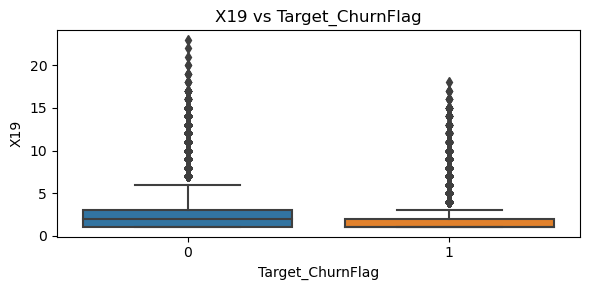

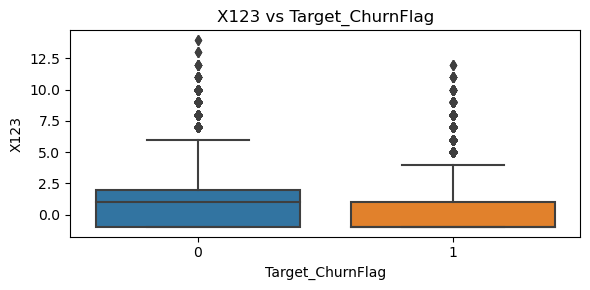

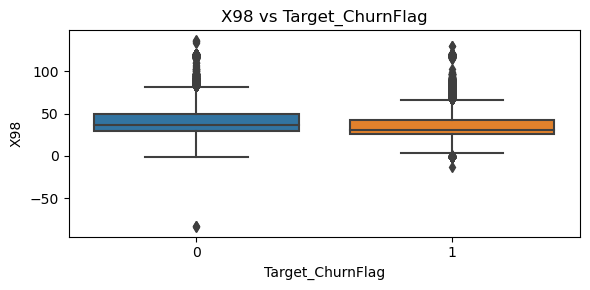

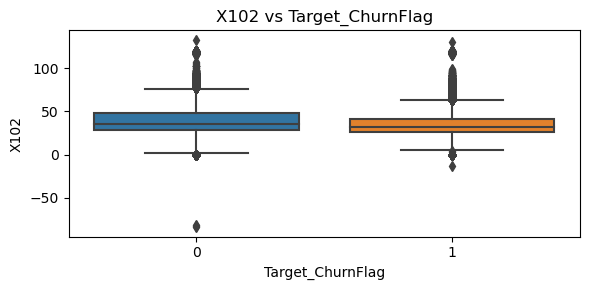

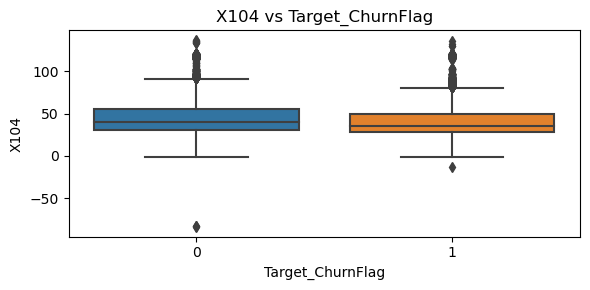

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = target_corr[1:6].index.tolist()

for col in top_features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x="Target_ChurnFlag", y=col, data=df)
    plt.title(f"{col} vs Target_ChurnFlag")
    plt.tight_layout()
    plt.show()

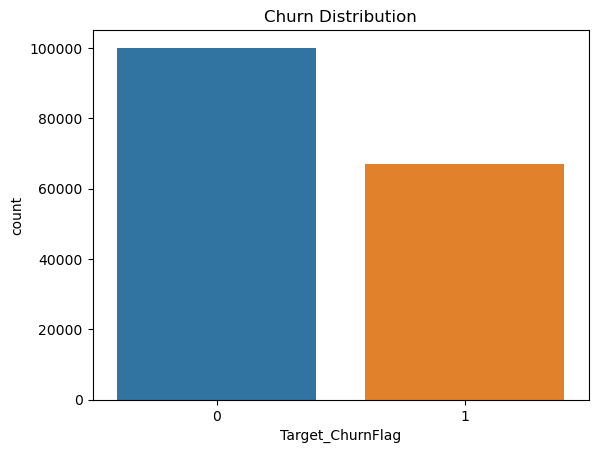

In [24]:
sns.countplot(x='Target_ChurnFlag', data=df)
plt.title("Churn Distribution")
plt.show()
#churn distribution

Top coorrelated

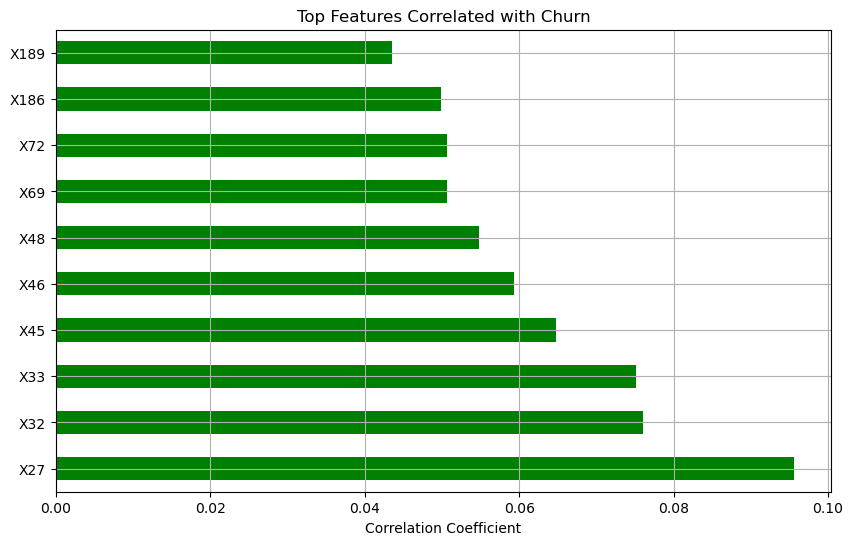

In [25]:
cor_matrix = df.corr(numeric_only=True)
target_corr = cor_matrix['Target_ChurnFlag'].drop('Target_ChurnFlag').sort_values(ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
target_corr.head(10).plot(kind='barh', color='green', label='Positive')
target_corr.tail(10).plot(kind='barh', color='red', label='Negative')
plt.title("Top Features Correlated with Churn")
plt.xlabel("Correlation Coefficient")
plt.grid(True)
plt.show()

In [26]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna("Unknown")
    elif col != "Target_ChurnFlag":
        df[col] = df[col].fillna(df[col].median())

In [27]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category',]).columns.tolist()

In [28]:
numerical_cols

['X1',
 'X12',
 'X13',
 'X14',
 'X15',
 'X17',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'X24',
 'X25',
 'X26',
 'X27',
 'Target_ChurnFlag',
 'X29',
 'X32',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X57',
 'X58',
 'X59',
 'X60',
 'X61',
 'X62',
 'X63',
 'X64',
 'X65',
 'X66',
 'X67',
 'X68',
 'X69',
 'X70',
 'X71',
 'X72',
 'X73',
 'X74',
 'X75',
 'X76',
 'X77',
 'X78',
 'X79',
 'X80',
 'X81',
 'X82',
 'X83',
 'X84',
 'X85',
 'X86',
 'X87',
 'X88',
 'X89',
 'X90',
 'X91',
 'X92',
 'X93',
 'X94',
 'X95',
 'X96',
 'X97',
 'X98',
 'X101',
 'X102',
 'X103',
 'X104',
 'X105',
 'X106',
 'X107',
 'X109',
 'X110',
 'X111',
 'X112',
 'X113',
 'X114',
 'X115',
 'X116',
 'X117',
 'X118',
 'X119',
 'X120',
 'X121',
 'X122',
 'X123',
 'X124',
 'X125',
 'X126',
 'X127',
 'X128',
 'X129',
 'X130',
 'X131',
 'X132',
 'X133',
 'X134',
 'X135',
 'X136',
 

In [29]:
categorical_cols

['X0',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X16',
 'X18',
 'X30',
 'X31',
 'X99',
 'X100',
 'X108',
 'X149',
 'X150',
 'X151',
 'X152',
 'X154',
 'X155',
 'X156',
 'X157',
 'X158',
 'X164',
 'X165',
 'X169',
 'X170']

In [30]:
for col in df.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [31]:
X = df.drop("Target_ChurnFlag", axis=1)
y = df["Target_ChurnFlag"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [32]:
clf = lgb.LGBMClassifier(random_state=42, n_estimators=100, learning_rate=0.05)
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 53516, number of negative: 80080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19259
[LightGBM] [Info] Number of data points in the train set: 133596, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400581 -> initscore=-0.403045
[LightGBM] [Info] Start training from score -0.403045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(learning_rate=0.05, random_state=42)

In [33]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [34]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20021
           1       1.00      1.00      1.00     13379

    accuracy                           1.00     33400
   macro avg       1.00      1.00      1.00     33400
weighted avg       1.00      1.00      1.00     33400

Confusion Matrix:
 [[20020     1]
 [    0 13379]]
ROC AUC Score: 0.9999997050708684


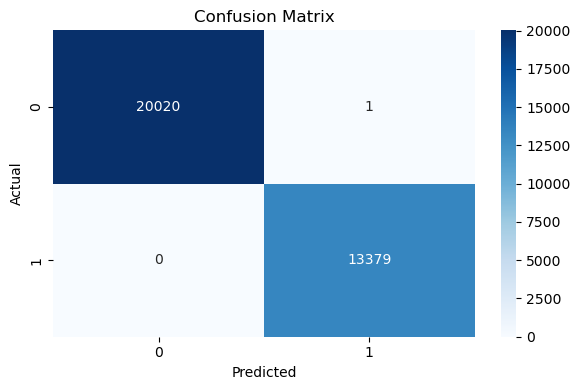

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()